# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [67]:
!python3 -m pip install nlpaug

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 101 kB 675 kB/s ta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [70]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger')

text = 'The quick brown fox jumps over the lazy dog .'

aug_syn = naw.SynonymAug(aug_src='wordnet')
# augmented_text = aug_syn.augment(text)
print("Original:")
print(text)
print("Augmented Synonym Text:")
for ii in range(5):
    augmented_text = aug_syn.augment(text)
    print(augmented_text)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/max/nltk_data...


Original:
The quick brown fox jumps over the lazy dog .
Augmented Synonym Text:
The quick brown fox bound over the work shy detent .
The quick brown george fox jump over the lazy andiron .
The quick john brown fox jumps ended the lazy cad .
The quick brown slyboots jumps terminated the lazy cad .
The nimble brown dodger jumps over the faineant dog .


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

from pprint import pprint 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

# https://stepik.org/lesson/256724/step/5?unit=237035

In [112]:
c = ["Казнить нельзя, помиловать. Нельзя наказывать.",
        "Казнить, нельзя помиловать. Нельзя освободить.",
        "Нельзя не помиловать.",
     "Обязательно освободить."
]
list_tokens = tokenize_corpus(c, min_token_size=1)
vocabulary, word_doc_freq = build_vocabulary(list_tokens, max_doc_freq=1., min_count=1)

In [117]:
vocabulary,word_doc_freq

({'помиловать': 0,
  'нельзя': 1,
  'казнить': 2,
  'освободить': 3,
  'наказывать': 4,
  'не': 5,
  'обязательно': 6},
 array([0.75, 0.75, 0.5 , 0.5 , 0.25, 0.25, 0.25], dtype=float32))

In [153]:
word_df = [(key, item) for key, item in zip(vocabulary.keys(), word_doc_freq)]
answer = sorted(word_df, key=lambda x:(x[1], x[0]))

answer_1 = []; 
answer_2 = [];

for k, v in list(answer):
    answer_1.append(k)
    answer_2.append(str(v))
    
print(" ".join(answer_1))
print(" ".join(answer_2))

наказывать не обязательно казнить освободить нельзя помиловать
0.25 0.25 0.25 0.5 0.5 0.75 0.75


In [178]:
vocabulary_sorted = {word:idx for word, idx in zip(answer_1, list(range(len(answer_1))))}
word_doc_freq_sorted = np.array(list(map(float,answer_2)))

# https://stepik.org/lesson/256724/step/7?unit=237035

In [203]:
import scipy
def my_vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'pmi'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1
                
    if mode == 'ltfidf':
#         print(result.A)
        result = np.log(result.toarray() + 1.)

        result = scipy.sparse.csc_matrix(result)
        
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова
        
        result = result.A
        result_std = result.std(0, ddof=1)
        result_mean = result.mean(0)
        result = (result - result_mean) / result_std
        result = scipy.sparse.csc_matrix(result)
        
    elif mode == 'pmi':
        # http://www.ccs.neu.edu/home/luwang/courses/cs6120_sp2018/slides_cs6120_sp18/semantics_part1.pdf
        matr_sum = result.sum()
        result = result.tocsr()
        result = result.multiply(1 / matr_sum)
        # https://stackoverflow.com/questions/20612769/how-to-get-sum-of-each-row-and-sum-of-each-column-in-scipy-sparse-matrices-csr
        result = result.multiply(matr_sum).multiply(1 / result.sum(0))
        result = result.multiply(matr_sum).multiply(1 / result.sum(1))
#         print(p_a)
#         print(p_b)
        
#         result = p_ab / (p_a * p_b)
        result = result.log1p()

    return result.tocsr()

In [204]:
VECTORIZATION_MODE = 'pmi'
vectors = my_vectorize_texts(list_tokens, vocabulary_sorted, word_doc_freq_sorted, mode=VECTORIZATION_MODE, scale=False)

In [205]:
vectors.A

array([[2.0433502, 0.       , 0.       , 1.4720612, 0.       , 1.3046957,
        1.1752046],
       [0.       , 0.       , 0.       , 1.6727737, 1.6727737, 1.4954937,
        1.357024 ],
       [0.       , 2.3779345, 0.       , 0.       , 0.       , 1.0840135,
        1.4494731],
       [0.       , 0.       , 2.3978953, 0.       , 1.7917595, 0.       ,
        0.       ]], dtype=float32)

In [185]:
from pprint import pprint
ar = vectors.A
for row in ar:
    for j in row:
        print(j, end=' ')
    print()

1.5 -0.5 -0.5 0.8660254037844386 -0.7571704455403936 0.5238074240735513 0.1846481320425394 
-0.5 -0.5 -0.5 0.8660254037844386 0.16270780348428954 0.5238074240735513 0.1846481320425394 
-0.5 1.5 -0.5 -0.8660254037844386 -0.7571704455403936 0.4515138383681435 1.01193455823273 
-0.5 -0.5 1.5 -0.8660254037844386 1.3516330875964977 -1.4991286865152464 -1.3812308223178094 


## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
pprint(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])
pprint(train_source.target_names[7])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

("From: lerxst@wam.umd.edu (where's my thing)\n"
 'Subject: WHAT car is this!?\n'
 'Nntp-Posting-Host: rac3.wam.umd.edu\n'
 'Organization: University of Maryland, College Park\n'
 'Lines: 15\n'
 '\n'
 ' I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.\n'
 '\n'
 'Thanks,\n'
 '- IL\n'
 '   ---- brought to you by your neighborhood Lerxst ----')

Метка 7
'rec.autos'


# data augmentaion

In [93]:
train_data = train_source['data']
train_target = train_source['target']

test_data = test_source['data']

### Подготовка признаков

In [97]:
train_tokenized = tokenize_corpus(train_data)
test_tokenized = tokenize_corpus(test_source['data'])

In [90]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')
def tokenize_text_simple_regex_bigram(txt, min_token_size=4):
    from nltk.util import ngrams
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    all_tokens = [token for token in all_tokens if len(token) >= min_token_size]
    list_ngrams = list(ngrams(all_tokens, 2))
    return [" ".join(token) for token in list_ngrams]

In [95]:
train_tokenized = tokenize_corpus(train_data)
test_tokenized = tokenize_corpus(train_data)

In [98]:
import nltk
#nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')

In [99]:
def preprocces_word(word):
    lemmatized = lemma.lemmatize(word)
    return sno.stem(lemmatized)

In [100]:
train_tokenized_lemmatized = [[preprocces_word(word) for word in sentence] for sentence in train_tokenized]
test_tokenized_lemmatized = [[preprocces_word(word) for word in sentence] for sentence in test_tokenized]

In [101]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized_lemmatized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 15820
[('that', 0), ('have', 1), ('this', 2), ('with', 3), ('write', 4), ('post', 5), ('articl', 6), ('host', 7), ('nntp', 8), ('univers', 9)]


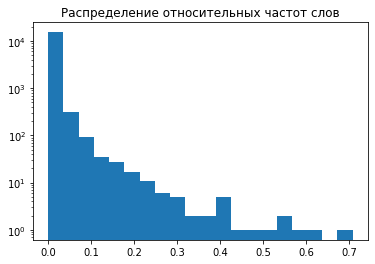

In [53]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [102]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized_lemmatized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized_lemmatized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 15820)
Размерность матрицы признаков тестовой выборки (11314, 15820)

Количество ненулевых элементов в обучающей выборке 1083640
Процент заполненности матрицы признаков 0.61%

Количество ненулевых элементов в обучающей выборке 698486
Процент заполненности матрицы признаков 0.59%


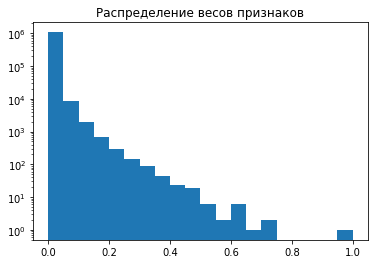

In [55]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [103]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


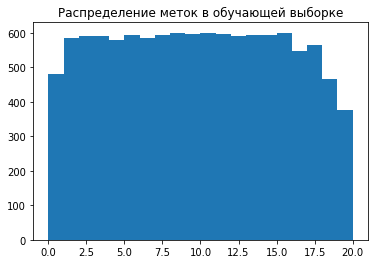

In [57]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

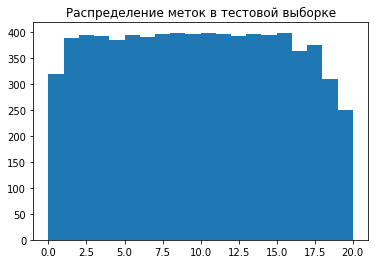

In [58]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [104]:
train_dataset = SparseFeaturesDataset(train_vectors, train_target)
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [110]:
!nvidia-smi


Tue May 26 20:55:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P3    15W /  N/A |    448MiB /  4040MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [109]:
torch.cuda.is_available()

False

In [111]:
# model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        n_hidden_neurons = 100
        self.fc1 = torch.nn.Linear(UNIQUE_WORDS_N, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, UNIQUE_LABELS_N)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x
    
model1 = model1()


scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model1,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Досрочно остановлено пользователем


## Оценка качества

In [63]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:01<00:00, 254.72it/s]
 11%|█▏        | 27/235.375 [00:00<00:00, 267.57it/s]

Среднее значение функции потерь на обучении 0.00762379402294755
Доля верных ответов 0.9993812975075128



236it [00:00, 259.36it/s]                             

Среднее значение функции потерь на валидации 0.9877116680145264
Доля верных ответов 0.7620817843866171


In [81]:
list(ngrams([1,2,3,4,5], 3))

[(1, 2, 3), (2, 3, 4), (3, 4, 5)]

In [82]:
from nltk.util import ngrams
[" ".join(i) for  i in list(ngrams(['1','2','3','4','5'], 3))]

['1 2 3', '2 3 4', '3 4 5']

In [64]:
from sklearn.metrics import confusion_matrix
from pprint import pprint
from sklearn.metrics import precision_score, recall_score
def print_metrics(loss, data, pred):
    y_true = data['target']
    y_pred = pred.argmax(-1)
    print('Среднее значение функции потерь', float(loss))
    print('Доля верных ответов', accuracy_score(data['target'], y_pred))
#     pprint(confusion_matrix(y_true, y_pred))
    print('Micro precision: ', precision_score(y_true, y_pred, average='micro'))
    print('Macro precision: ', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall: ', recall_score(y_true, y_pred, average='micro'))
    print('Macro recall: ', recall_score(y_true, y_pred, average='macro'))

print('test')
print_metrics(test_loss, test_source, test_pred)
print('-------------')
print('train')
print_metrics(train_loss, train_source, train_pred)

test
Среднее значение функции потерь 0.9877116680145264
Доля верных ответов 0.7620817843866171
Micro precision:  0.7620817843866171
Macro precision:  0.7653707624773157
Macro recall:  0.7620817843866171
Macro recall:  0.7582728806444642
-------------
train
Среднее значение функции потерь 0.00762379402294755
Доля верных ответов 0.9993812975075128
Micro precision:  0.9993812975075128
Macro precision:  0.9994070499328453
Macro recall:  0.9993812975075128
Macro recall:  0.9994060272030115


Baseline:

Среднее значение функции потерь на обучении 0.0041749742813408375
Доля верных ответов 0.9992929114371575                           

Среднее значение функции потерь на валидации 0.9288848042488098
Доля верных ответов 0.7712426978226234

С лемматизацией:

Среднее значение функции потерь на обучении 0.005697958171367645
Доля верных ответов 0.9994696835778681
                         

Среднее значение функции потерь на валидации 0.9548155069351196
Доля верных ответов 0.7644715878916623


# Альтернативная реализация на scikit-learn

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [66]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918573367
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582332423
Доля верных ответов 0.8190387679235263


Baseline

Среднее значение функции потерь на обучении 2.4954788918573367
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582332423
Доля верных ответов 0.8190387679235263